In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.externals import joblib
# import lesson_functions
from lesson_functions import *

In [2]:
#load file names of images
car_images = glob.glob('vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


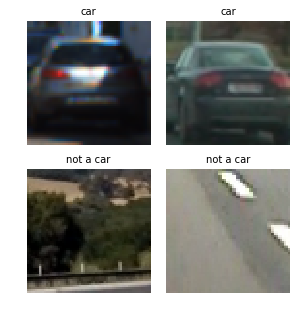

In [3]:
#display images of car and not cars
fig, axs = plt.subplots(2,2, figsize=(5, 5))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(2):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(2,4):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not a car', fontsize=10)
    axs[i].imshow(img)

In [4]:
# function to extract feature for training set
def get_features(files, color_space='RGB', spatial_size=(32, 32),hist_bins=32, orient=9, pix_per_cell=8, 
                 cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in files:
        
        img = mpimg.imread(file)
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        features.append(img_features)
    return features

In [5]:
#initialize parameters 

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

#extract features 
car_features = get_features(car_images,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcar_features = get_features(noncar_images,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Fit  scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)

#train test split 
X_train_cars,X_test_cars,y_train_cars,y_test_cars = train_test_split(scaled_X[:len(car_images)], y[:len(car_images)], 
                                                                     test_size=0.2, random_state=rand_state)
X_train_ncars,X_test_ncars,y_train_ncars,y_test_ncars = train_test_split(scaled_X[len(car_images):], y[len(car_images):], 
                                                                     test_size=0.2, random_state=rand_state)
X_train = np.vstack((X_train_cars, X_train_ncars))
y_train = np.hstack((y_train_cars, y_train_ncars))
X_test = np.vstack((X_test_cars, X_test_ncars))
y_test = np.hstack((y_test_cars, y_test_ncars))

# shuffle datasets 
X_train,y_train = shuffle(X_train,y_train,random_state=rand_state)
X_test,y_test = shuffle(X_test,y_test,random_state=rand_state)



C:\Users\Chaitanya\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
# Train a linear SVC
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
# Check the score for the classifier
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.989


In [7]:
from sklearn.externals import joblib
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from scipy.ndimage.measurements import label

In [8]:
#read test images
images = sorted(glob.glob('test_images/test*.jpg'))

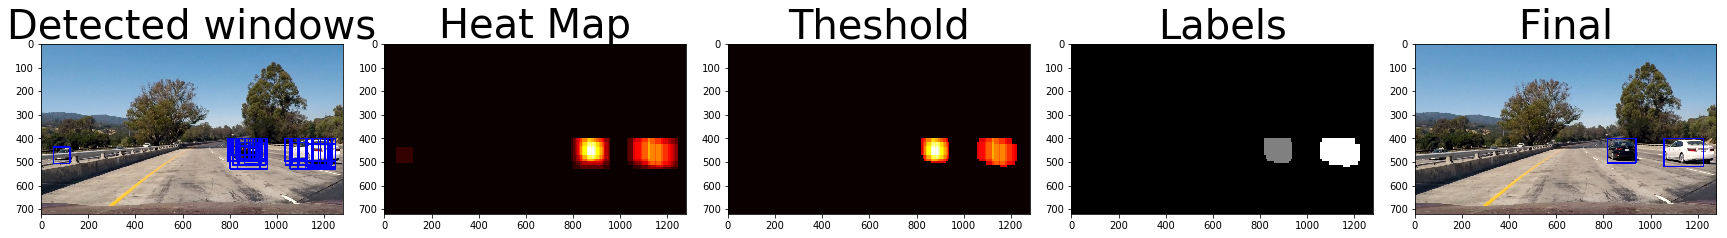

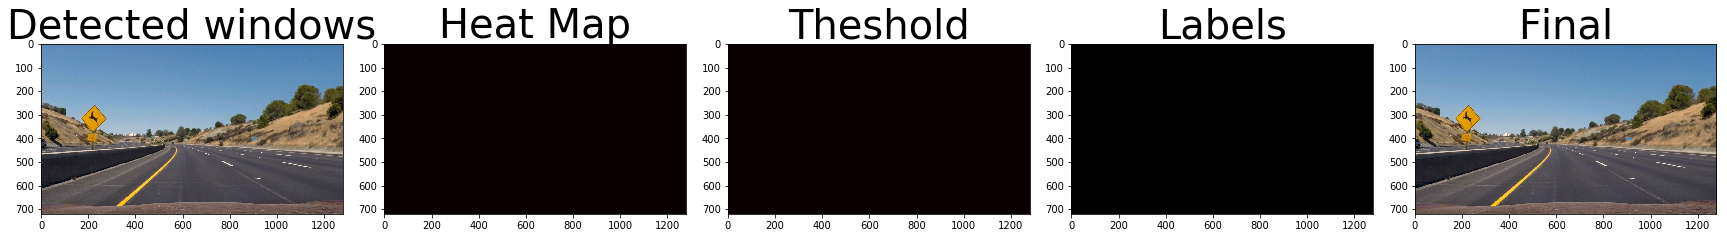

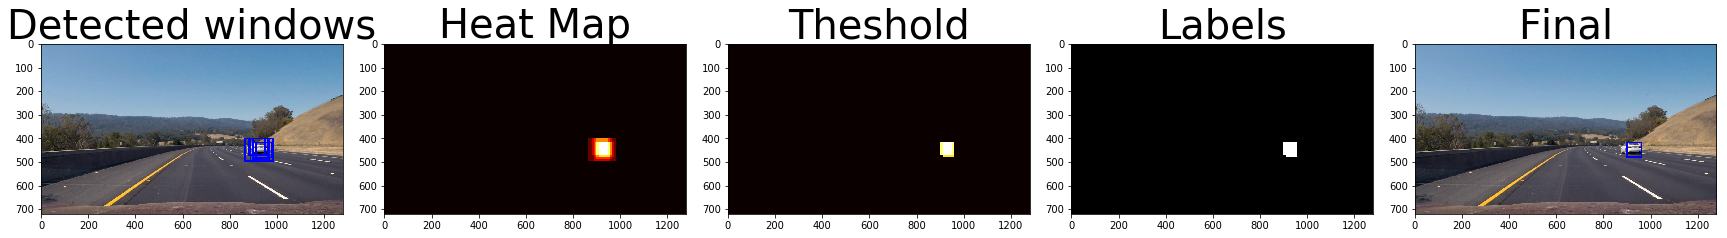

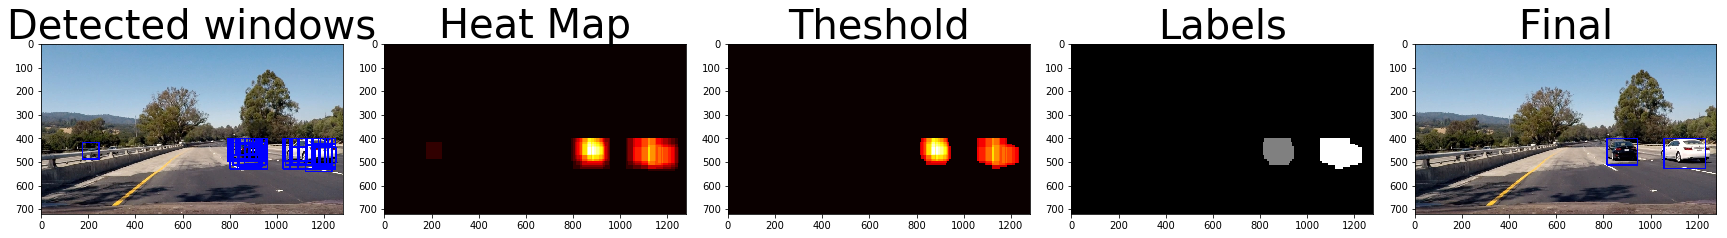

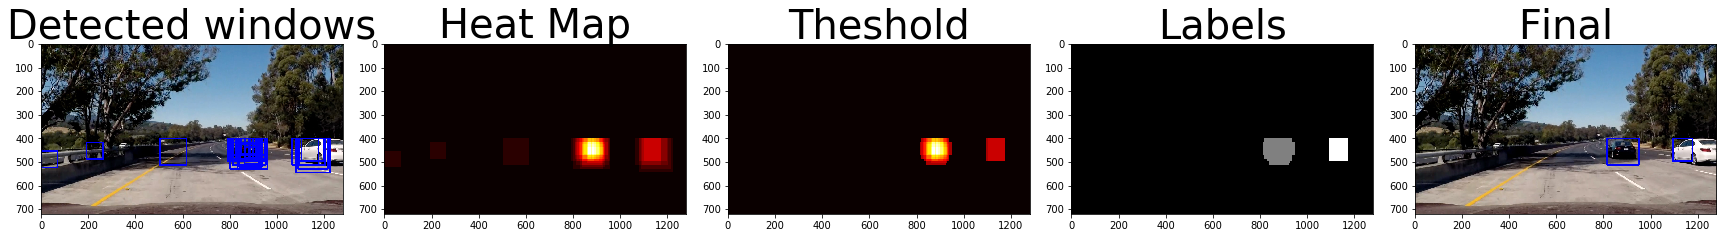

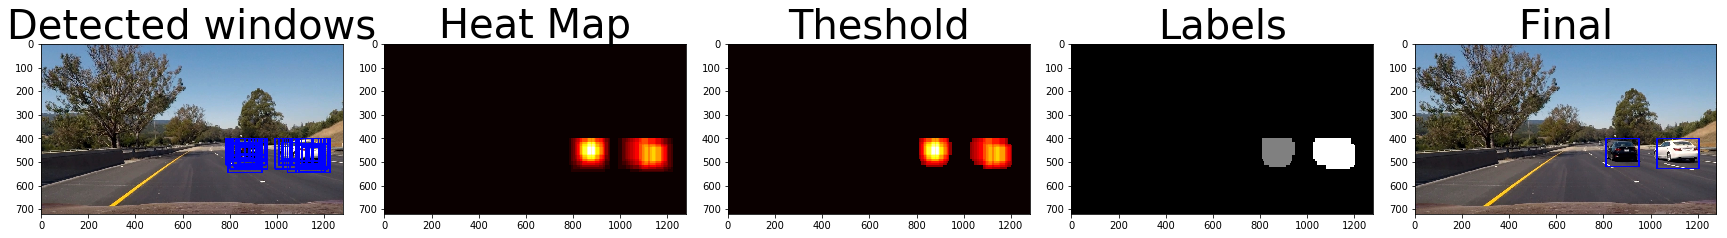

In [9]:
#experiment and develop pipeline 

ystart = (400,400,400,400,400,400,400,400)
ystop = (570,570,570,570,570,600,656,656)
scale = (1,1.1,1.5,1.75,2,2.25,2.75,3.5)


#ystart = 400
#ystop = 656
#scale = (1.25,1.5,2,2.5,3.25)

for file in images:


    image = mpimg.imread(file)
    all_boxes_d = []
    
    for i in range(len(scale)):
        boxes_d = find_cars(image, ystart=ystart[i], ystop=ystop[i], scale=scale[i], svc=svc, X_scaler = X_scaler,
                                    orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    spatial_size=spatial_size,hist_bins=hist_bins,color_space=color_space,
                                    show_all_rectangles=False)
        
        all_boxes_d += boxes_d
        
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, all_boxes_d)
        
    
    plt.figure(1)    
    # Plot the result
    f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(draw_boxes(image, all_boxes_d, color=(0, 0, 255), thick=6))
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(heatmap_img, cmap='hot')
    ax2.set_title('Heat Map', fontsize=40)
    
    heatmap_img = apply_threshold(heatmap_img, 4) #threshold =4
    
    ax3.imshow(heatmap_img,cmap='hot')
    ax3.set_title('Theshold', fontsize=40)
    
    labels = label(heatmap_img)
    ax4.imshow(labels[0], cmap='gray')
    ax4.set_title('Labels', fontsize=40)
    
    draw_img, rects = draw_labeled_bboxes(image, labels)
    
    ax5.imshow(draw_img)
    ax5.set_title('Final', fontsize=40)
    
    plt.show()


    

In [10]:
#pipeline for vehicle detection 
def pipeline(image):

    ystart = 400
    ystop = 656
    scale = (1,1.5,2,2.5,3)
    threshold = 1
    
    #ystart = (400,400,400,400,400,400,400,400)
    #ystop = (570,570,570,570,570,600,656,656)
    #scale = (1,1.1,1.5,1.75,2,2.25,2.75,3.5)
    
    all_boxes = []
    
    for i in range(len(scale)):
        # using modified lesson function
        boxes = find_cars(image, ystart=ystart, ystop=ystop, scale=scale[i], svc=svc, X_scaler = X_scaler,
                                    orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    spatial_size=spatial_size,hist_bins=hist_bins,color_space=color_space,
                                    show_all_rectangles=False)
        all_boxes += boxes
        
       
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, all_boxes)
        
    heatmap_img = apply_threshold(heatmap_img, threshold)
    
    labels = label(heatmap_img)
        
    draw_img, bbox = draw_labeled_bboxes(image, labels)
    
    
    return draw_img
    
    

In [11]:
# check the pipeline on the video
out_dir='./output_images/'
inpfile='project_video.mp4'
outfile=out_dir+'processed_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(pipeline) 
%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_project_video.mp4
[MoviePy] Writing video ./output_images/processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [32:53<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_project_video.mp4 

Wall time: 32min 54s


In [12]:
out_dir='./output_images/'
inpfile='test_video.mp4'
outfile=out_dir+'processed_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(pipeline) 
%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_test_video.mp4
[MoviePy] Writing video ./output_images/processed_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:58<00:01,  1.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_test_video.mp4 

Wall time: 59.4 s
